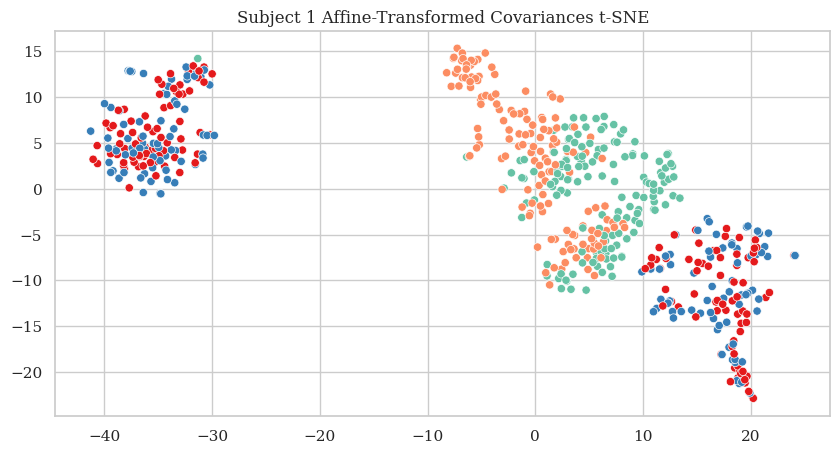

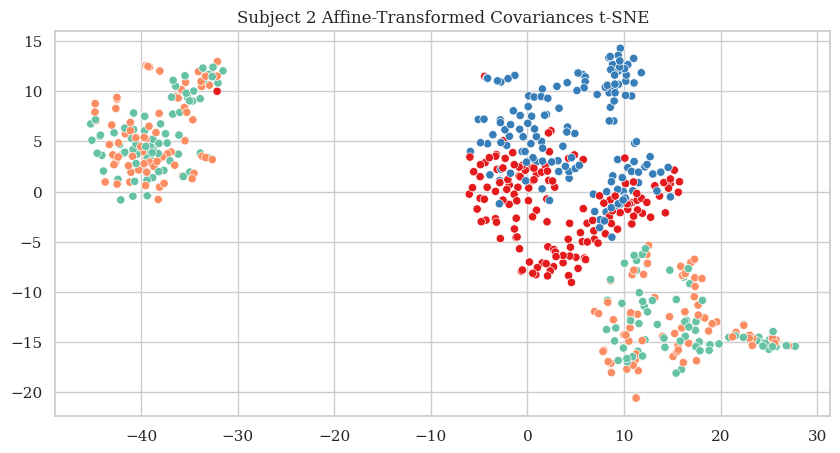

Subject 1
MDM Accuracy: 0.47
Bayesian Accuracy: 0.47
GMM Accuracy (n_components=2): 0.54

Subject 2
MDM Accuracy: 0.49
Bayesian Accuracy: 0.51
GMM Accuracy (n_components=2): 0.51



In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import scipy.signal
import scipy.linalg
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from moabb.datasets import BNCI2014_001
from moabb.paradigms import LeftRightImagery
from pyriemann.utils.mean import mean_riemann
from pyriemann.utils.distance import distance_riemann

###############################################################################
# Helpers: Covariance, Riemannian distance, reference state, affine transform #
###############################################################################

def compute_covariance(trials):
    """
    Compute empirical covariance matrices for a list/array of EEG trials.
    trials shape: (n_trials, n_channels, n_samples)
    """
    cov_matrices = []
    for x in trials:
        cov_matrices.append(np.cov(x))
    return np.array(cov_matrices)

def compute_reference_state(covmats):
    """
    Compute the reference state as the Riemannian mean of a group of SPD matrices.
    """
    return mean_riemann(covmats)

def affine_transform(covmats, reference):
    """
    Apply the affine transformation:
    C -> R^(-1/2) * C * R^(-1/2)
    """
    ref_sqrt_inv = np.linalg.inv(scipy.linalg.sqrtm(reference))
    return np.array([ref_sqrt_inv @ c @ ref_sqrt_inv for c in covmats])

###############################################################################
# Classification Methods
#   1) MDM classifier (eq. 7)
#   2) Bayesian classifier with unequal sigmas (eq. 8)
#   3) Gaussian Mixture Model classifier (mixtures of Riemannian Gaussian, eq. 6)
###############################################################################

def mdm_classify(cov_train, y_train, cov_test):
    """
    Minimum Distance to Mean (MDM) classification.

    1) Compute Riemannian mean for each class
    2) Assign each test trial to class with min Riemannian distance
    """
    classes = np.unique(y_train)
    means = {}
    for c in classes:
        means[c] = mean_riemann(cov_train[y_train == c])
    
    predictions = []
    for test_cov in cov_test:
        # Compute distance to each class mean
        dists = {}
        for c in classes:
            dists[c] = distance_riemann(test_cov, means[c])
        # Pick class with minimal distance
        predictions.append(min(dists, key=dists.get))
    
    return np.array(predictions)

def bayesian_classify(cov_train, y_train, cov_test):
    """
    Bayesian classification (eq. 8).
    Each class: Riemannian mean = center of mass, plus MLE for sigma.

    Classification rule:
      arg min_k { log(zeta(sigma_k)) + dR^2(C, mean_k) / [2 * sigma_k^2] }
    We do not need to compute log(zeta(sigma_k)) precisely for comparison,
    but we include log(sigma_k) for approximate effect. 
    """
    classes = np.unique(y_train)
    means = {}
    sigmas = {}

    # Estimate mean and sigma for each class
    for c in classes:
        cov_per_class = cov_train[y_train == c]
        means[c] = mean_riemann(cov_per_class)
        # Distances for MLE of sigma
        dists = [distance_riemann(cov_, means[c]) for cov_ in cov_per_class]
        sigmas[c] = np.sqrt(np.mean(np.square(dists))) if len(dists) > 0 else 1e-9

    predictions = []
    for test_cov in cov_test:
        scores = {}
        # We compare log(sigma_k) + d^2 / (2 sigma_k^2)
        for c in classes:
            d2 = distance_riemann(test_cov, means[c]) ** 2
            # We skip the constant log(zeta(sigma_k)) because it doesn't change the arg min
            # Use an approximate version: Score = log(sigma_k) + d2 / (2*sigma_k^2)
            # The class with the smallest score is chosen
            score = np.log(sigmas[c]) + (d2 / (2.0 * (sigmas[c] ** 2)))
            scores[c] = score
        predictions.append(min(scores, key=scores.get))
    
    return np.array(predictions)

def gmm_classify(cov_train, y_train, cov_test, n_components=2):
    """
    Mixture of Gaussians classifier (eq. 6 but fitted in Euclidean space).
    In the strict sense, a Riemannian Gaussian mixture model should be done on SPD manifold
    with Riemannian metrics, but here we show an approximate approach using Euclidean GMM
    on flattened SPD matrices.

    For each class, fit a GMM with n_components. Then for each test trial, assign the class
    that yields the highest log-likelihood or smallest negative log-likelihood.
    """
    classes = np.unique(y_train)
    models = {}

    # Flatten SPD matrices for GMM in Euclidean space
    X_train_flat = cov_train.reshape(cov_train.shape[0], -1)
    X_test_flat = cov_test.reshape(cov_test.shape[0], -1)

    # Fit a GMM for each class
    for c in classes:
        sub_data = X_train_flat[y_train == c]
        gmm = GaussianMixture(n_components=n_components, random_state=42)
        gmm.fit(sub_data)
        models[c] = gmm

    # Predict
    predictions = []
    for row in X_test_flat:
        # For each class, compute negative log likelihood
        # Then pick the class with smallest negative log-likelihood
        best_class = None
        best_score = float('inf')
        for c in classes:
            neg_ll = -models[c].score_samples([row])[0]
            if neg_ll < best_score:
                best_score = neg_ll
                best_class = c
        predictions.append(best_class)
    
    return np.array(predictions)

###############################################################################
# Example Pipeline
#   1) Load BNCI2014_001 dataset
#   2) Filter data (8-30 Hz)
#   3) Compute covariance matrices
#   4) Possibly apply affine transform to handle cross-subject
#   5) Classify with MDM, Bayesian, or GMM
#   6) Visualize embeddings using t-SNE
###############################################################################

def bandpass_eeg(data, sfreq, lowcut=8, highcut=30, order=5):
    """
    Apply a Butterworth bandpass filter (8-30 Hz by default) along last dimension.
    data shape: (n_channels, n_samples)
    """
    b, a = scipy.signal.butter(order, [lowcut/(sfreq/2), highcut/(sfreq/2)], btype='band')
    return scipy.signal.filtfilt(b, a, data)

# Load BNCI2014_001 dataset
dataset = BNCI2014_001()
subject_list = dataset.subject_list  # typically 9 subjects: [1..9]
sfreq = 250.0  # sampling frequency in BNCI2014_001

# For demonstration, pick a subset of subjects here
subjects_to_use = [1, 2]
paradigm = LeftRightImagery()
# results for demonstration
acc_results_mdm = []
acc_results_bayes = []
acc_results_gmm = []

for test_subj in subjects_to_use:
    # Train on all other subjects, test on test_subj
    train_subjs = [s for s in subjects_to_use if s != test_subj]

    X_train_all = []
    y_train_all = []
    for subj in train_subjs:
        # moabb returns a dict with subject data
        raw_data, raw_labels, _ = paradigm.get_data(dataset=dataset, subjects=[subj], return_epochs=False)
        # raw_data is (n_trials, n_channels, n_times)
        # raw_labels is vector of size n_trials
        # Filter each trial in band 8-30Hz
        filtered = []
        for trial in raw_data:
            filt_data = bandpass_eeg(trial, sfreq, 8, 30, order=5)
            filtered.append(filt_data)
        X_train_all.append(np.array(filtered))
        y_train_all.append(raw_labels)

    X_train_all = np.concatenate(X_train_all, axis=0)
    y_train_all = np.concatenate(y_train_all, axis=0)

    # Test data
    X_test, y_test, _ = paradigm.get_data(dataset=dataset, subjects=[test_subj], return_epochs=False)
    filtered_test = []
    for trial in X_test:
        filt_data = bandpass_eeg(trial, sfreq, 8, 30, order=5)
        filtered_test.append(filt_data)
    X_test = np.array(filtered_test)

    # Compute SPD covariance
    cov_train = compute_covariance(X_train_all)
    cov_test = compute_covariance(X_test)

    # Optionally do an affine transform to handle cross-subject
    ref_train = compute_reference_state(cov_train)
    ref_test = compute_reference_state(cov_test)

    cov_train_affine = affine_transform(cov_train, ref_train)
    cov_test_affine = affine_transform(cov_test, ref_test)

    # 1) MDM classification
    y_pred_mdm = mdm_classify(cov_train_affine, y_train_all, cov_test_affine)
    acc_mdm = np.mean(y_pred_mdm == y_test)
    acc_results_mdm.append(acc_mdm)

    # 2) Bayesian classification
    y_pred_bayes = bayesian_classify(cov_train_affine, y_train_all, cov_test_affine)
    acc_bayes = np.mean(y_pred_bayes == y_test)
    acc_results_bayes.append(acc_bayes)

    # 3) GMM classification (example with 2 components)
    y_pred_gmm = gmm_classify(cov_train_affine, y_train_all, cov_test_affine, n_components=2)
    acc_gmm = np.mean(y_pred_gmm == y_test)
    acc_results_gmm.append(acc_gmm)

    # Visualize the embeddings with t-SNE
    combined_cov = np.concatenate([cov_train_affine, cov_test_affine], axis=0)
    combined_labels = np.concatenate([y_train_all, y_test], axis=0)
    n_matrices = combined_cov.shape[0]

    # Flatten for standard t-SNE in Euclidean space
    combined_cov_flat = combined_cov.reshape(n_matrices, -1)
    tsne = TSNE(n_components=2, random_state=42)
    embeddings = tsne.fit_transform(combined_cov_flat)

    plt.figure(figsize=(10, 5))
    sns.scatterplot(
        x=embeddings[:len(y_train_all), 0],
        y=embeddings[:len(y_train_all), 1],
        hue=y_train_all,
        style=['train']*len(y_train_all),
        palette='Set1',
        legend=False
    )
    sns.scatterplot(
        x=embeddings[len(y_train_all):, 0],
        y=embeddings[len(y_train_all):, 1],
        hue=y_test,
        style=['test']*len(y_test),
        palette='Set2',
        legend=False
    )
    plt.title(f"Subject {test_subj} Affine-Transformed Covariances t-SNE")
    plt.show()

# Print final results
for i, subj in enumerate(subjects_to_use):
    print(f"Subject {subj}")
    print(f"MDM Accuracy: {acc_results_mdm[i]:.2f}")
    print(f"Bayesian Accuracy: {acc_results_bayes[i]:.2f}")
    print(f"GMM Accuracy (n_components=2): {acc_results_gmm[i]:.2f}")
    print()
